
# Comparação LSTM vs XLSTM (Hiperparâmetros Otimizados)

Notebook para comparar dois modelos (LSTM e XLSTM) para séries temporais, cada um com seus hiperparâmetros otimizados.

**Coloque o arquivo `major-crime-indicators.csv` na mesma pasta ou faça upload quando solicitado.**


In [23]:

# !pip install torch pandas numpy matplotlib scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando dispositivo:', device)


Usando dispositivo: cpu


In [24]:

csv_path = 'major-crime-indicators.csv'

if not os.path.exists(csv_path):
    from tkinter import Tk
    from tkinter.filedialog import askopenfilename
    print('Arquivo CSV não encontrado! Selecione o arquivo para upload.')
    try:
        root = Tk()
        root.withdraw()
        up = askopenfilename(title='Selecione major-crime-indicators.csv')
        if up:
            import shutil
            shutil.copy(up, csv_path)
            print('Arquivo copiado com sucesso:', csv_path)
        else:
            raise Exception('Nenhum arquivo selecionado.')
    except Exception as e:
        print('Upload não realizado:', e)
        raise
else:
    print('Arquivo encontrado:', csv_path)


Arquivo encontrado: major-crime-indicators.csv


C:\Users\peder\AppData\Local\Temp\ipykernel_1692\1187435964.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M', on='REPORT_DATE')


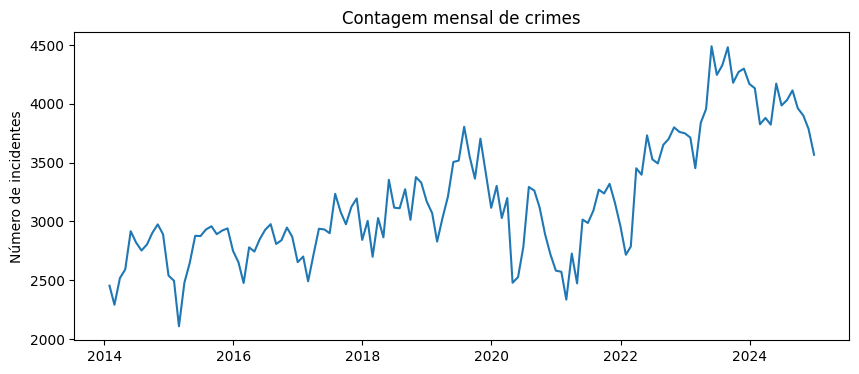

In [25]:

# Carrega e agrupa por mês
df = pd.read_csv(csv_path, parse_dates=['REPORT_DATE'], low_memory=False)
df = df[df['REPORT_DATE'].notna()].sort_values('REPORT_DATE')
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
monthly_counts = (
    df.resample('M', on='REPORT_DATE')
    .size()
    .rename('count')
    .to_frame()
    .sort_index()
)

plt.figure(figsize=(10, 4))
plt.plot(monthly_counts.index, monthly_counts['count'])
plt.title('Contagem mensal de crimes')
plt.ylabel('Número de incidentes')
plt.show()

# Normaliza
scaler = MinMaxScaler()
monthly_counts['scaled'] = scaler.fit_transform(monthly_counts[['count']])
data = monthly_counts['scaled'].values


In [26]:

# Função para criar X, y
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

# Para LSTM
X_lstm, y_lstm = create_windows(data, 6)
split_lstm = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_lstm], X_lstm[split_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:split_lstm], y_lstm[split_lstm:]

# Para XLSTM
X_xlstm, y_xlstm = create_windows(data, 12)
split_xlstm = int(len(X_xlstm) * 0.8)
X_train_xlstm, X_test_xlstm = X_xlstm[:split_xlstm], X_xlstm[split_xlstm:]
y_train_xlstm, y_test_xlstm = y_xlstm[:split_xlstm], y_xlstm[split_xlstm:]


In [27]:

class SeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Batch size de cada
batch_size_lstm = 8
batch_size_xlstm = 8

train_ds_lstm = SeriesDataset(X_train_lstm, y_train_lstm)
test_ds_lstm = SeriesDataset(X_test_lstm, y_test_lstm)
train_loader_lstm = DataLoader(train_ds_lstm, batch_size=batch_size_lstm, shuffle=True)
test_loader_lstm = DataLoader(test_ds_lstm, batch_size=batch_size_lstm)

train_ds_xlstm = SeriesDataset(X_train_xlstm, y_train_xlstm)
test_ds_xlstm = SeriesDataset(X_test_xlstm, y_test_xlstm)
train_loader_xlstm = DataLoader(train_ds_xlstm, batch_size=batch_size_xlstm, shuffle=True)
test_loader_xlstm = DataLoader(test_ds_xlstm, batch_size=batch_size_xlstm)


## Modelo LSTM (hidden_size=64, dropout=0.3)

In [28]:

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

lstm_model = LSTMModel(hidden_size=64, dropout=0.3).to(device)


c:\Users\peder\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


## Modelo XLSTM (hidden_size=128, dropout=0.02, 3 camadas)

In [29]:

class XLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=3, dropout=0.02):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out).squeeze()

xlstm_model = XLSTMModel(hidden_size=128, dropout=0.02).to(device)


In [30]:

def train_model(model, train_loader, test_loader, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        history['train_loss'].append(np.mean(losses))
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                out = model(Xb)
                loss = criterion(out, yb)
                val_losses.append(loss.item())
        history['val_loss'].append(np.mean(val_losses))
        if (epoch+1) % (epochs // 5) == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train loss: {history['train_loss'][-1]:.4f} | Val loss: {history['val_loss'][-1]:.4f}")
    return history


In [31]:

# LSTM
epochs_lstm = 1000
print("Treinando LSTM...")
lstm_history = train_model(
    lstm_model, train_loader_lstm, test_loader_lstm,
    epochs=epochs_lstm, lr=0.005
)

# XLSTM
epochs_xlstm = 180
print("\nTreinando XLSTM...")
xlstm_model = XLSTMModel(hidden_size=128, dropout=0.02).to(device)  # reinicia
xlstm_history = train_model(
    xlstm_model, train_loader_xlstm, test_loader_xlstm,
    epochs=epochs_xlstm, lr=0.007829
)


Treinando LSTM...
Epoch 1/1000 | Train loss: 0.0910 | Val loss: 0.2469
Epoch 200/1000 | Train loss: 0.0068 | Val loss: 0.0096
Epoch 400/1000 | Train loss: 0.0006 | Val loss: 0.0146
Epoch 600/1000 | Train loss: 0.0000 | Val loss: 0.0218
Epoch 800/1000 | Train loss: 0.0000 | Val loss: 0.0258
Epoch 1000/1000 | Train loss: 0.0001 | Val loss: 0.0273

Treinando XLSTM...
Epoch 1/180 | Train loss: 0.3248 | Val loss: 0.2227
Epoch 36/180 | Train loss: 0.0100 | Val loss: 0.0137
Epoch 72/180 | Train loss: 0.0058 | Val loss: 0.0151
Epoch 108/180 | Train loss: 0.0023 | Val loss: 0.0414
Epoch 144/180 | Train loss: 0.0010 | Val loss: 0.0516
Epoch 180/180 | Train loss: 0.0003 | Val loss: 0.0476


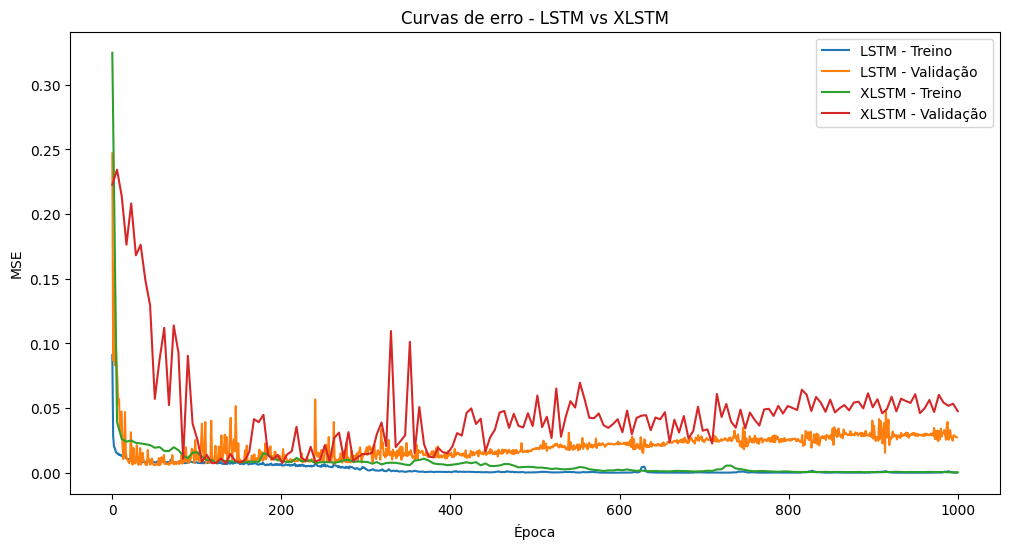

In [32]:

plt.figure(figsize=(12,6))
plt.plot(lstm_history['train_loss'], label='LSTM - Treino')
plt.plot(lstm_history['val_loss'], label='LSTM - Validação')
plt.plot(np.linspace(0, len(lstm_history['val_loss']), len(xlstm_history['val_loss'])), xlstm_history['train_loss'], label='XLSTM - Treino')
plt.plot(np.linspace(0, len(lstm_history['val_loss']), len(xlstm_history['val_loss'])), xlstm_history['val_loss'], label='XLSTM - Validação')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.title('Curvas de erro - LSTM vs XLSTM')
plt.legend()
plt.show()


In [33]:

def final_eval(model, X_test, y_test):
    model.eval()
    X = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(X).cpu().numpy()
    mse = np.mean((pred - y_test)**2)
    mae = np.mean(np.abs(pred - y_test))
    rmse = np.sqrt(mse)
    print(f"MSE: {mse:.5f} | RMSE: {rmse:.5f} | MAE: {mae:.5f}")
    return pred

print("LSTM:")
_ = final_eval(lstm_model, X_test_lstm, y_test_lstm)
print("XLSTM:")
_ = final_eval(xlstm_model, X_test_xlstm, y_test_xlstm)


LSTM:
MSE: 0.03321 | RMSE: 0.18224 | MAE: 0.14716
XLSTM:
MSE: 0.04760 | RMSE: 0.21818 | MAE: 0.18789
